## 集成算法

集成已迅速成为应用机器学习中最热门和最流行的方法之一。尤其是在竞赛和提高模型精度方向！

推荐阅读：http://ml-ensemble.com/

## bagging
<img src="1.png" style="width:600px;height:400px;float:left">

对于数据源X，分别选择两种预处理方案，在不同预处理方案中再建立不同模型，最终汇总所有模型结果

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

### Import data
# Always good to set a seed for reproducibility
SEED = 222
np.random.seed(SEED)

df = pd.read_csv('yeast.csv')

In [2]:
### Training and test set
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score #导入评价标准

# 做数据预处理，并进行数据划分,测试集占95%,为了训练速度快
def get_train_test(test_size=0.3):
    """Split Data into train and test sets."""
    y = df.Y #做标签
    X = df.drop(["Y"], axis=1) #去掉该列数据
    return train_test_split(X, y, test_size=test_size, random_state=SEED)

xtrain, xtest, ytrain, ytest = get_train_test()

# A look at the data
print("\nExample data:")
df.head()


Example data:


,X1,X2,X3,X4,X5,X6,X7,X8,Y
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,7
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,7
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,7
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,8
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,7


In [3]:
print(xtrain.shape,xtest.shape, ytrain.shape, ytest.shape)
print(type(df))

(1038, 8) (446, 8) (1038,) (446,)
<class 'pandas.core.frame.DataFrame'>


* cand_pty_affiliation：我们要预测的指标，共和党或者民主党
* entity_tp：个人还是组织
* classification:领域
* rpt_tp：贡献的大小
* cycle：捐赠在哪年
* transaction_amt：捐献金额


## ROC 与 AUC

<img src="11.png" alt="FAO" width="690" >
* TP(True Positive)：将正类预测为正类数，真实为0，预测也为0

* FN(False Negative)：将正类预测为负类数，真实为0，预测为1

* FP(False Positive)：将负类预测为正类数， 真实为1，预测为0

* TN(True Negative)：将负类预测为负类数，真实为1，预测也为1

<img src="10.png" alt="FAO" width="690" >

接下来我们考虑ROC曲线图中的四个点和一条线：

* 第一个点，(0,1)，即FPR=0, TPR=1，这意味着FN（false negative）=0，并且FP（false positive）=0。Wow，这是一个完美的分类器，它将所有的样本都正确分类。
* 第二个点，(1,0)，即FPR=1，TPR=0，类似地分析可以发现这是一个最糟糕的分类器，因为它成功避开了所有的正确答案。
* 第三个点，(0,0)，即FPR=TPR=0，即FP（false positive）=TP（true positive）=0，可以发现该分类器预测所有的样本都为负样本（negative）。类似的。
* 第四个点（1,1），分类器实际上预测所有的样本都为正样本。经过以上的分析，我们可以断言，ROC曲线越接近左上角，该分类器的性能越好。

* 下面考虑ROC曲线图中的虚线y=x上的点。这条对角线上的点其实表示的是一个采用随机猜测策略的分类器的结果，例如(0.5,0.5)，表示该分类器随机对于一半的样本猜测其为正样本，另外一半的样本为负样本。

AUC（Area Under Curve）被定义为ROC曲线下的面积，显然这个面积的数值不会大于1。又由于ROC曲线一般都处于y=x这条直线的上方，所以AUC的取值范围在0.5和1之间。使用AUC值作为评价标准是因为很多时候ROC曲线并不能清晰的说明哪个分类器的效果更好，而作为一个数值，对应AUC更大的分类器效果更好。

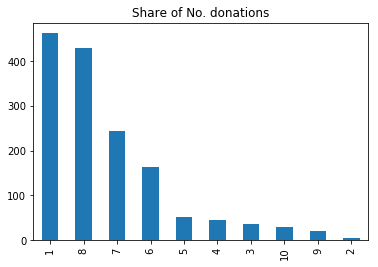

8     0.304933
1     0.271300
7     0.172646
6     0.109865
4     0.049327
5     0.040359
10    0.020179
3     0.020179
9     0.011211
Name: Y, dtype: float64


In [4]:
#统计数据的比例,注意修改df的属性Y
# df.Y.value_counts(normalize=True).plot(kind="bar", title="Share of No. donations")
# normalize=True，数据比例进行归一化
df.Y.value_counts().plot(kind="bar", title="Share of No. donations")
plt.show()
print(ytest.value_counts(normalize=True))

## 构建几个基本的决策树模型来看看

In [5]:
import pydotplus  # you can install pydotplus with: pip install pydotplus 
#安装graphviz  http://download.csdn.net/download/shouwangzhelv/9492517
#将安装或者解压的graphviz下的bin目录添加到系统的path中，重启notebook
from IPython.display import Image
from sklearn.metrics import roc_auc_score #导入roc评价模块
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import os
os.environ["PATH"] += os.pathsep + 'E:/Graphviz/bin/'

def print_graph(clf, feature_names,):
    """Print decision tree."""
    graph = export_graphviz(
        clf,
        label="all",
        proportion=True,
        impurity=False, 
        out_file=None, 
        feature_names=feature_names,
        class_names= ['1','2','3','4','5','6','7','8','9','10'], 
        filled=True,
        rounded=True
    )
    graph = pydotplus.graph_from_dot_data(graph)  
    return Image(graph.create_png())

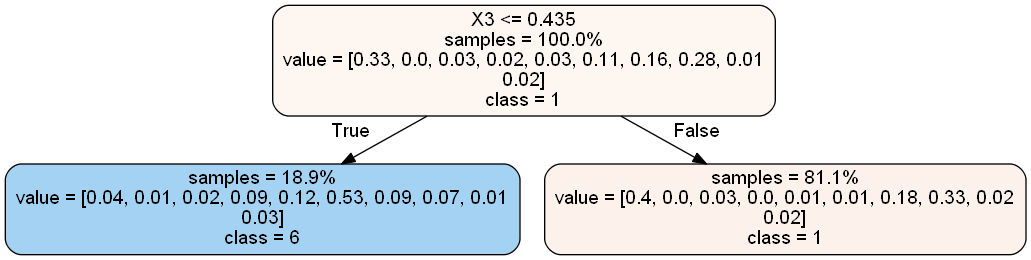

In [6]:
#决策树模块
t1 = DecisionTreeClassifier(max_depth=1,random_state=SEED)
clf = t1.fit(xtrain, ytrain)

#这里的最后列标是随意的，对结果不影响，暂时不知道有什么不一样
# p = t1.predict_proba(xtest)[:, 0]
# p = t1.predict_proba(xtest)[:, 2]
P = t1.predict_proba(xtest)
p = np.max(P,1)#输出的是概率
cp = clf.predict(xtest) #输出的是标签
# print(p,cp)
# print(clf.predict(xtest)[0:5]) #这个得到的是真正的标签
# print(np.sum(t1.predict_proba(xtest)[0:5,:],1)) #测试是否为每个类别的概率，是的
# print(t1.predict_proba(xtest)[1,:],t1.predict_proba(xtest)[1,1])
# print(t1.predict_proba(xtest).shape,t1.predict_proba(xtest)[0:5,:])
print_graph(t1, xtrain.columns)

### 评价指标：

In [7]:
# print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p)) #roc曲线不支持多类别
print(metrics.adjusted_mutual_info_score(ytest, p)) #计算调整互信息

#下面两个都是计算准确率的
print(np.mean(ytest == cp))
print(metrics.accuracy_score(ytest, cp)) #计算准确率，

0.16487493262
0.374439461883
0.374439461883


In [8]:
#绘制多分类的ROC曲线,这实际上是绘制的每一个类别的roc曲线，意义不是很大
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
def Graph_Mul_ROC(y_test, y_score):
    #y_test:真实标签
    #y_score:在测试集上计算得分

    # 计算每一类的ROC
    n_classes = y_score.shape[1]
    classes = range(0,n_classes)
    
    # 将标签二值化,就是对标签进行one-hot encoding
    y_test = label_binarize(y_test, classes)
   
    #用来存储roc曲线上的值
    fpr = dict() #负正类
    tpr = dict() #正正类
    roc_auc = dict() #roc值

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area（方法二）
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area（方法一）
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    lw=2
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.rcParams['figure.figsize'] = (15,10) 
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

D:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


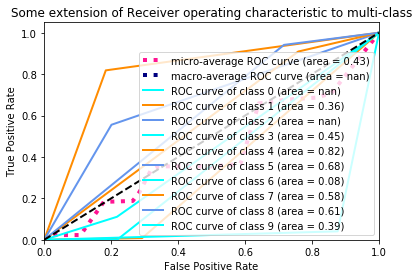

In [9]:
Graph_Mul_ROC(ytest, P)

In [10]:
print(p.shape)
aa=np.random.rand(2,2)
print(aa)
print(np.sum(aa,1))
print(np.max(aa,1))

(446,)
[[ 0.52602843  0.68531719]
 [ 0.83567419  0.65376526]]
[ 1.21134561  1.48943945]
[ 0.68531719  0.83567419]


### 关于决策树的解释：
* value：每个类别的真实比例

In [11]:
ytrain.value_counts(normalize=True)

1     0.329480
8     0.282274
7     0.160886
6     0.109827
5     0.031792
3     0.025048
4     0.021195
10    0.020231
9     0.014451
2     0.004817
Name: Y, dtype: float64

## 增加深度

0.21596074528
0.565022421525


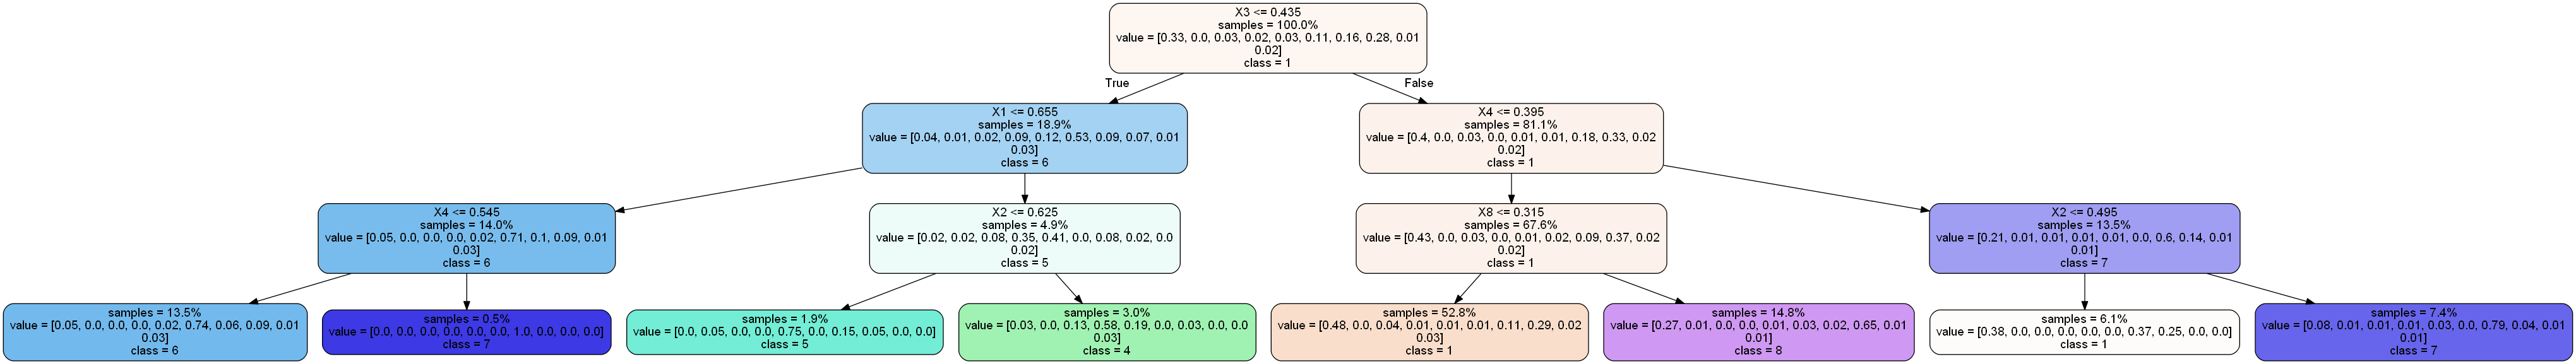

In [12]:
t2 = DecisionTreeClassifier(max_depth=3, random_state=SEED)
clf2 = t2.fit(xtrain, ytrain)
p = t2.predict_proba(xtest)[:, 1]
cp2 =  clf2.predict(xtest)
# print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print(metrics.adjusted_mutual_info_score(ytest, p)) #计算调整互信息
print(metrics.accuracy_score(ytest, cp2)) #计算准确率
print_graph(t2, xtrain.columns)

## 我们来调整下策略，去掉个对结果有着最大影响的因素再来看看！

0.147683404608
0.470852017937


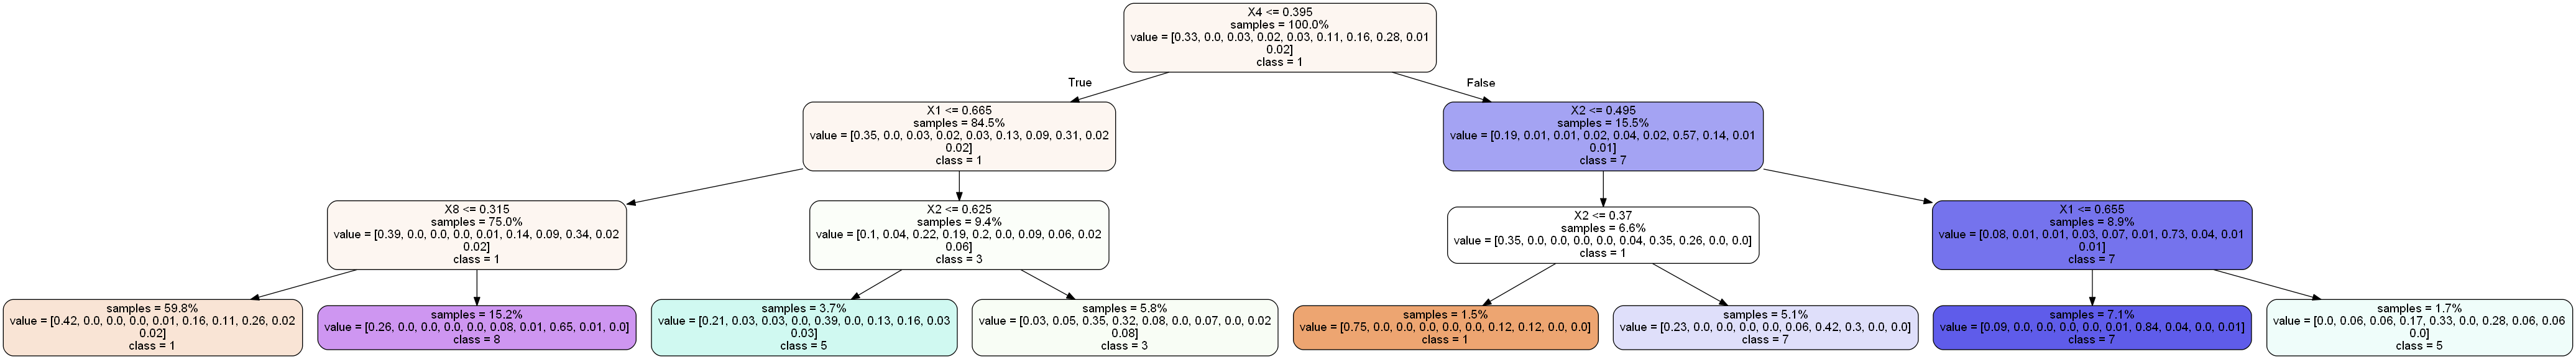

In [13]:
drop = ["X3"]

xtrain_slim = xtrain.drop(drop, 1)
xtest_slim = xtest.drop(drop, 1)

t3 = DecisionTreeClassifier(max_depth=3, random_state=SEED)
clf3 = t3.fit(xtrain_slim, ytrain)
p = t3.predict_proba(xtest_slim)[:, 1]
cp3 = clf3.predict(xtest_slim)

# print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print(metrics.adjusted_mutual_info_score(ytest, p)) #计算调整互信息
print(np.mean(ytest == cp3))
print_graph(t3, xtrain_slim.columns)

# Bagging：训练多个分类器取平均

In [14]:
p1 = t2.predict_proba(xtest)[:, 1]
p2 = t3.predict_proba(xtest_slim)[:, 1]
p = np.mean([p1, p2], axis=0)
print(metrics.adjusted_mutual_info_score(ytest, p)) #计算调整互信息
# print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

0.342794122416


## 诶呀妈呀，整了个平均还真比原来高了！

这么一说，应该是选择不同的特征会产生不同的结果，然后用不同的结果再进行组合得到了一个升华！那我们多选几组不就是随机森林了嘛！
#### 这里不知道为什么随机森林的效果反而更差,这里可能是互信息的评价问题，看准确率的确是上升状态

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=10,
    max_features=3,
    random_state=SEED
)
#n_estimators:森林的个数
#max_features:寻找最佳分割时要考虑的特性的数量
clf = rf.fit(xtrain, ytrain)
p = rf.predict_proba(xtest)[:, 1]
cp = clf.predict(xtest)
print(metrics.adjusted_mutual_info_score(ytest, p)) #计算调整互信息
print(np.mean(ytest == cp))
# print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

0.011992215499
0.565022421525


这小分刷的嗖嗖的！

<img src="2.png" style="width:500px;height:350px;float:left">
<img src="5.png" style="width:400px;height:200px;float:left">

## 来吧兄弟们！一起上了！

In [16]:
# A host of Scikit-learn models
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline


def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=100, random_state=SEED)
    nn = MLPClassifier((80, 10), early_stopping=False, random_state=SEED)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)

    models = {'svm': svc,
              'knn': knn,
              'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm': gb,
              'logistic': lr,
              }

    return models


def ACC_train_predict(model_list):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        clf = m.fit(xtrain, ytrain)
#         P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        P.iloc[:, i] = clf.predict(xtest)
        cols.append(name)
        print("done")
    P.columns = cols
    print("Done.\n")
    return P

def ACC_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = metrics.accuracy_score(ytest, P.loc[:,m])    #计算准确率
        print("%-36s: %.3f" % (m, score))
    print("Done.\n")
    
#这个函数定义了将所有模型进行加和平均得到的结果
def ACC_AII_Model(model_list):
    """Fit models in list on training set and return preds"""
    P = []
    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        clf = m.fit(xtrain, ytrain)
        p = m.predict_proba(xtest) #(446, 10)
#         print(p[0:2,:])
        P.append(p) 
        print('done')
    print("Done.\n")  
    P_sum = np.zeros(p.shape)
    for p in P:
        P_sum += p
    P_avg = P_sum/len(model_list)
    P_label = P_sum.argmax(1)+1    
    return(P_label, P_avg)

## 打印每个模型下的精度

In [17]:
models = get_models()
P = ACC_train_predict(models)
ACC_models(P, ytest)

Fitting models.
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done
Done.

Scoring models.
svm                                 : 0.605
knn                                 : 0.538
naive bayes                         : 0.182
mlp-nn                              : 0.599
random forest                       : 0.565
gbm                                 : 0.612
logistic                            : 0.587
Done.



### 打印算法的相关性

[MLENS] backend: threading
[MLENS] Found 1 residual cache(s):
        1 (4096): C:\Users\ADMINI~1\AppData\Local\Temp\.mlens_tmp_cache_7ic5jcnz
        Total size: 4096
[MLENS] Removing... done.


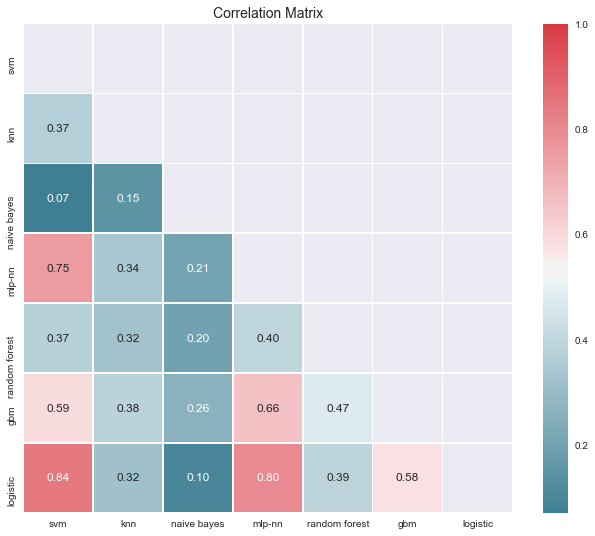

In [18]:
# You need ML-Ensemble for this figure: you can install it with: pip install mlens
from mlens.visualization import corrmat
corrmat(P.corr(), inflate=False)
plt.show()

预测的结果很多都是高度相关的！

In [19]:
models = get_models()
P_label, P_avg = ACC_AII_Model(models)
print(metrics.accuracy_score(ytest, P_label))

Fitting models.
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done
Done.

0.621076233184


新纪录诞生了！

集成算法一方面使得边界更平稳，一方面使得效果更好！

D:\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


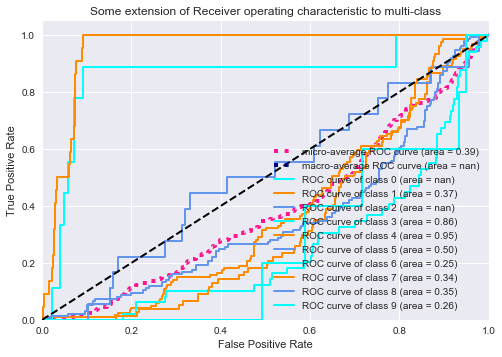

In [20]:
#打印所有类别的ROC曲线
Graph_Mul_ROC(ytest, P_avg)

# Boosting
咱们之前的集成都是按照平均来算的，但是这样公平吗？有些拖后腿的咋办呢？

个别模型根本捕捉不到一些类别！这对我们来说是不利的，那集成里面是不是得剔除掉它啊！

把效果最烂的那个给开除了！

接下来我们得想一个办法，老是自己挑选不是那么个事啊？我能不能让机器自己选择该怎么用这些基础模型呢？

<img src="7.png" style="width:200px;height:100px;float:left">
<img src="8.png" style="width:300px;height:70px;float:left">

对于每一个基础模型，选择一个最合适的权重，但是这些权重我们来怎么定义呢？那就让我们训练一个模型来定义这些权重吧！

在这里我们需要考虑一点？第二个模型的输入应该是什么呢？这需要重点考虑！

# Stacking模型

1.定义我们的基础模型

In [21]:
base_learners = get_models()

2.定义我们的权重分配模型（第二层架构）

In [31]:
meta_learner = GradientBoostingClassifier(
    n_estimators=1000,
    loss="deviance",
    max_features=4,
    max_depth=3,
    subsample=0.5,
    learning_rate=0.005, 
    random_state=SEED
)

3.将基础模型分成两部分，主要供第二层来使用

In [23]:
xtrain_base, xpred_base, ytrain_base, ypred_base = train_test_split(
    xtrain, ytrain, test_size=0.5, random_state=SEED)

4.训练我们的基础模型

In [24]:
def train_base_learners(base_learners, inp, out, verbose=True):
    """Train all base learners in the library."""
    if verbose: print("Fitting models.")
    for i, (name, m) in enumerate(base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        m.fit(inp, out)
        if verbose: print("done")

In [25]:
train_base_learners(base_learners, xtrain_base, ytrain_base)

Fitting models.
svm... done
knn... done
naive bayes... done
mlp-nn... 

D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


done
random forest... done
gbm... done
logistic... done


现在已经训练好了基本分类器，但是我们二阶段要求的输入是一阶段木有看过的那些！

<img src="9.png" style="width:400px;height:70px;float:left">

5.准备二阶段权重分配分类器的训练数据

In [26]:
def predict_base_learners(pred_base_learners, inp, verbose=True):
    """Generate a prediction matrix."""
    P = np.zeros((inp.shape[0], len(pred_base_learners)))

    if verbose: print("Generating base learner predictions.")
    for i, (name, m) in enumerate(pred_base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        p = m.predict_proba(inp)
        # With two classes, need only predictions for one class
        P[:, i] = p[:, 1]
        if verbose: print("done")

    return P

In [27]:
P_base = predict_base_learners(base_learners, xpred_base)

Generating base learner predictions.
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done


In [28]:
P_base.shape

(519, 7)

In [29]:
P_base[0]

array([  9.52631466e-04,   0.00000000e+00,   0.00000000e+00,
         2.62741116e-05,   0.00000000e+00,   6.69811815e-06,
         6.82363527e-05])

6.训练二阶段得出分类结果！

In [35]:
clf = meta_learner.fit(P_base, ypred_base)

In [37]:
def ensemble_predict(base_learners, clf, inp, verbose=True):
    """Generate predictions from the ensemble."""
    P_pred = predict_base_learners(base_learners, inp, verbose=verbose)
#     return P_pred, meta_learner.predict_proba(P_pred)[:, 1]
    return P_pred, clf.predict(P_pred)

In [38]:
P_pred, p = ensemble_predict(base_learners, meta_learner, xtest)
print(metrics.accuracy_score(ytest, p))

Generating base learner predictions.
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done
0.508968609865


结果还不错！

划分为训练集和测试集虽然能满足咱们的要求，但是好像损失了一部分数据啊？那怎么办？用交叉验证来搞定！

In [39]:
from sklearn.base import clone

def stacking(base_learners, meta_learner, X, y, generator):
    """Simple training routine for stacking."""

    # Train final base learners for test time
    print("Fitting final base learners...", end="")
    train_base_learners(base_learners, X, y, verbose=False)
    print("done")

    # Generate predictions for training meta learners
    # Outer loop:
    print("Generating cross-validated predictions...")
    cv_preds, cv_y = [], []
    for i, (train_idx, test_idx) in enumerate(generator.split(X)):

        fold_xtrain, fold_ytrain = X[train_idx, :], y[train_idx]
        fold_xtest, fold_ytest = X[test_idx, :], y[test_idx]

        # Inner loop: step 4 and 5
        fold_base_learners = {name: clone(model)
                              for name, model in base_learners.items()}
        train_base_learners(
            fold_base_learners, fold_xtrain, fold_ytrain, verbose=False)

        fold_P_base = predict_base_learners(
            fold_base_learners, fold_xtest, verbose=False)

        cv_preds.append(fold_P_base)
        cv_y.append(fold_ytest)
        print("Fold %i done" % (i + 1))

    print("CV-predictions done")
    
    # Be careful to get rows in the right order
    cv_preds = np.vstack(cv_preds)
    cv_y = np.hstack(cv_y)

    # Train meta learner
    print("Fitting meta learner...", end="")
    meta_learner.fit(cv_preds, cv_y)
    print("done")

    return base_learners, meta_learner

In [41]:
from sklearn.model_selection import KFold

# Train with stacking
cv_base_learners, cv_meta_learner = stacking(
    get_models(), clone(meta_learner), xtrain.values, ytrain.values, KFold(2))

P_pred, p = ensemble_predict(cv_base_learners, cv_meta_learner, xtest, verbose=False)
print(metrics.accuracy_score(ytest, p))

Fitting final base learners...done
Generating cross-validated predictions...


D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Fold 1 done


D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Fold 2 done
CV-predictions done
Fitting meta learner...done
0.40134529148


现在我们来想一想，这样的方法有啥问题呢？是不是速度会比较慢呀！推荐大家用下面的并行方法，速度大大提升！

# 并行化处理

## 出问题

In [50]:
from mlens.ensemble import SuperLearner

# Instantiate the ensemble with 10 folds
sl = SuperLearner(
    folds=10,
    random_state=SEED,
    verbose=2,
    backend="multiprocessing"
)

# Add the base learners and the meta learner
sl.add(list(base_learners.values()), proba=True) 
sl.add_meta(meta_learner, proba=True)

# Train the ensemble
clf = sl.fit(xtrain, ytrain)

# Predict the test set
# p_sl = clf.predict(xtest)
p_sl = sl.predict_proba(xtest)
p = p_sl.argmax(1)

print(metrics.accuracy_score(ytest, p))


Fitting 2 layers
Processing layer-1             done | 00:00:10
Processing layer-2             done | 00:00:08
Fit complete                        | 00:00:19

Predicting 2 layers
Processing layer-1             done | 00:00:03
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:04
0.0291479820628
